# Analysis of Titanic Data

# Question
Which one of the main factors provided in the data set (age, gender, class, size of family) made passengers likely to survive?

In [112]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [113]:
def calculate_rate(df, column):
    rate = df[column].value_counts()/len(df)*100
    return rate

# Define some functions to plot data
def plot_bar_multi(data, ax, title, xlabel, ylabel, y_low, y_high):
    """Plots a bar chart in a multipanel figure"""
    data.plot(ax = ax, kind = 'bar', title = title, rot = 0)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(xlabel, fontsize=12)
    ax.set_ylim(y_low, y_high)

def plot_bar_single(data, title, xlabel, ylabel):
    """Plots a single bar chart"""
    data.plot(kind = 'bar', title = title, rot = 0)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.show()
    
def plot_hist(hist_data, ax, title, xlabel, ylabel):
    """Plots histtogram data in a multipanel figure"""
    hist_data.plot(kind = 'bar', rot = 0)
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)  


#Data Wrangling:


We begin answering the question by reading the data, looking at the data, and obtaining some basic information. 

In [114]:
# Read the data and output the head
titanic_data = pd.read_csv('titanic_data.csv')
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [115]:
# Get some basic information
print titanic_data.info()
print titanic_data.describe()
# Print the number of duplicated passenger ids
num_duplicate_ids = len(titanic_data['PassengerId']) - len(titanic_data['PassengerId'].unique())
print str(num_duplicate_ids) + ' passenger ids duplicated'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.

It seems there are some missing values in "Age" column and there are many missing values in "Cabin" column.
I'm not sure how "Cabin" information can be helpful but I think we need to fill-in the missing "Age" values

# Fill-in the missing "Age" values

I think an accurate way to fill-in the missing values in the age column would be using the corresponding mean values of
ages for the class and gender of that passenger

In [116]:
# add a new column to assign the missing ages
titanic_data['filled_age'] = titanic_data['Age']
# Find the average age for each class and gender
avg_age_by_class = titanic_data.groupby([titanic_data['Sex'], titanic_data['Pclass']]).mean()['Age']
print avg_age_by_class

Sex     Pclass
female  1         34.611765
        2         28.722973
        3         21.750000
male    1         41.281386
        2         30.740707
        3         26.507589
Name: Age, dtype: float64


In [117]:
# Find the gender and class of each passenger and replace the missing age
# by the average of that class and gender (not sure how we could do this using vertorized operations)
for i in range(len(titanic_data)):
    gender = titanic_data['Sex'].iloc[i]
    pclass = titanic_data['Pclass'].iloc[i]
    if not pd.notnull(titanic_data['filled_age'].iloc[i]):
        titanic_data['filled_age'].iloc[i] = avg_age_by_class.loc[gender,pclass]
# Print the tail to see if the age of PassengerId=889 was replaced by correct value and if there is any NaN values left
print titanic_data[['PassengerId','filled_age']].tail()
print len(titanic_data[titanic_data['filled_age'].isnull()])


     PassengerId  filled_age
886          887       27.00
887          888       19.00
888          889       21.75
889          890       26.00
890          891       32.00
0


Everything looks good

# Data Exploration

Plot the data in a multipanel figure to get some initial information. In my opinion, it makes more sense to plot the percentages rather than frequency when possible

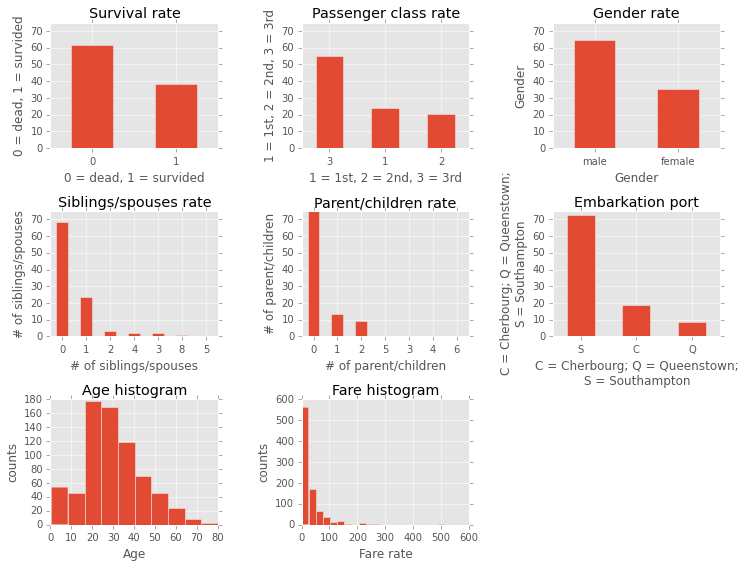

In [118]:
   
fig1, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3)
plt.gcf().set_size_inches(12, 9)
y_low = 0
y_high = 75

# To adjust the distance subplots
fig1.subplots_adjust(wspace = 0.5, hspace = 0.5)

# Plot survival rates
survival_rate = calculate_rate(titanic_data, 'Survived')
plot_bar_multi(survival_rate, ax1, 'Survival rate', '0 = dead, 1 = survided',
          '%', y_low, y_high)

# Plot Pclass rates
pclass_rate = calculate_rate(titanic_data, 'Pclass')
plot_bar_multi(pclass_rate, ax2, 'Passenger class rate', '1 = 1st, 2 = 2nd, 3 = 3rd',
         '%', y_low, y_high)

# Plot gender rates
gender_rate = calculate_rate(titanic_data, 'Sex')
plot_bar_multi(gender_rate, ax3, 'Gender rate', 'Gender',
         '%', y_low, y_high)

# Plot siblings/spouses rates
sibsp_rate = calculate_rate(titanic_data, 'SibSp')
plot_bar_multi(sibsp_rate, ax4, 'Siblings/spouses rate', '# of siblings/spouses',
         '%', y_low, y_high)

# Plot parent/children rates
parch_rate = calculate_rate(titanic_data, 'Parch') 
plot_bar_multi(parch_rate, ax5, 'Parent/children rate', '# of parent/children',
         '%', y_low, y_high)

# Plot Embarkation port rates
embarked_rate = calculate_rate(titanic_data, 'Embarked')
plot_bar_multi(embarked_rate, ax6, 'Embarkation port', 'C = Cherbourg; Q = Queenstown;\n'
                'S = Southampton', '%', y_low, y_high)

# Plot age histogram
age_hist =  titanic_data['Age'].hist(ax = ax7)
plot_hist(age_hist, ax7, 'Age histogram', 'Age', 'counts')

# Plot fare histogram
fare_hist =  titanic_data['Fare'].hist(ax = ax8, bins=20)
plot_hist(fare_hist, ax8, 'Fare histogram', 'Fare rate', 'counts')

# Remove the subplot that wasn't used
fig1.delaxes(ax9)

# Show the figure
plt.show()


It appears 
1) more than 60% of pepople couldn't survive. 
2) number of passengers in class 3 dominates
3) There were more male than female on board
4) The peak of age was around 20-30 years old

Find what percentages of passengers in each class survived

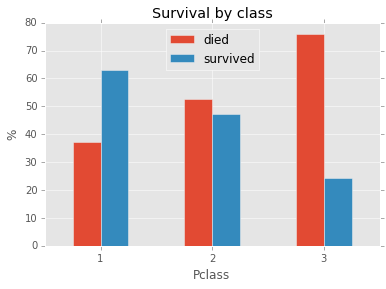

In [119]:
class_survival = pd.crosstab(titanic_data['Pclass'], titanic_data['Survived'])
# Compute the percentage
class_survival_prc = class_survival.div(class_survival.sum(axis = 1)/100, axis = 0)
# Change the column name to be less confusing
class_survival_prc.columns = ['died', 'survived']
# Plot the data
plot_bar_single(class_survival_prc, 'Survival by class',
                'Pclass', '%')

It seems the survival rate was higher in class 1 passengers in contrast to class 2 and 3 

Find out what percentages of each gender survived

Survived    0    1
Sex               
female     81  233
male      468  109
                0           1
count    2.000000    2.000000
mean   274.500000  171.000000
std    273.650324   87.681241
min     81.000000  109.000000
25%    177.750000  140.000000
50%    274.500000  171.000000
75%    371.250000  202.000000
max    468.000000  233.000000


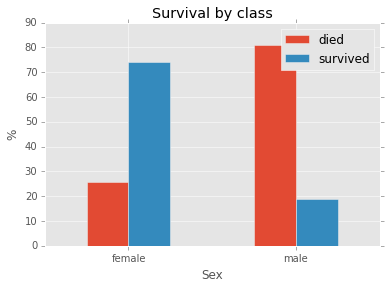

In [120]:
gender_survival = pd.crosstab(titanic_data['Sex'], titanic_data['Survived'])
print gender_survival
print gender_survival.describe()
# Compute the percentage
gender_survival_prc = gender_survival.div(gender_survival.sum(axis = 1)/100, axis = 0)
# Change the column name so that the plot will be less confusing
gender_survival_prc.columns = ['died', 'survived']
# Plot the data
plot_bar_single(gender_survival_prc, 'Survival by class',
                'Sex', '%')

Apparently the survival rate was much higher in females than males. Let's see if the higher survival rate of females is related to passenger's class or this is true for all passenger classes


56.4814814815 % male   passengers in class 1
43.5185185185 % female passengers in class 1
58.6956521739 % male   passengers in class 2
41.3043478261 % female passengers in class 2
70.6720977597 % male   passengers in class 3
29.3279022403 % female passengers in class 3


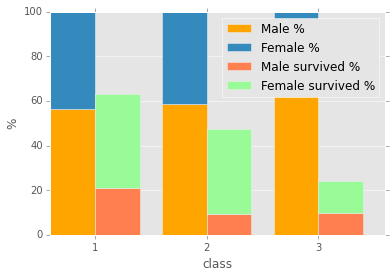

In [121]:
# Find the number of males and females in each class
p_classes = sorted(titanic_data['Pclass'].unique())
male_passengers = []
female_passengers = []
for c in p_classes:
    male_passengers.append(len(titanic_data[(titanic_data['Sex'] == 'male') &
                                        (titanic_data['Pclass'] == c)]))
    female_passengers.append(len(titanic_data[(titanic_data['Sex'] == 'female') &
                                            (titanic_data['Pclass'] == c)]))
male_passengers_prc = []
female_passengers_prc = []
# Calculate the percentages of male and female passengers
for i in xrange(0,len(male_passengers)):
    total_pass_in_class = male_passengers[i] + female_passengers[i]
    male_passengers_prc.append(float(male_passengers[i]) /
                            total_pass_in_class * 100)
    female_passengers_prc.append(float(female_passengers[i]) /
                            total_pass_in_class * 100)
# Print the percentages of male and female passengers
for i in xrange(0, len(male_passengers)):
    print '{} % male   passengers in class {}'.\
        format(male_passengers_prc[i], p_classes[i])
    print '{} % female passengers in class {}'.\
        format(female_passengers_prc[i], p_classes[i])
# Caculate survival rate by gender and class
# Collect males data
male_data = titanic_data[titanic_data['Sex'] == 'male']
male_survival = pd.crosstab(male_data['Pclass'], titanic_data['Survived'])
# Collect females data
female_data = titanic_data[titanic_data['Sex'] == 'female']
female_survival = pd.crosstab(female_data['Pclass'], titanic_data['Survived'])

# Compute the percentage
male_survival_prc = male_survival.div(male_survival.sum(axis = 1)/100 + 
                                      female_survival.sum(axis = 1)/100, axis = 0).values
# Compute the percentage
female_survival_prc = female_survival.div(female_survival.sum(axis = 1)/100 + 
                                          male_survival.sum(axis = 1)/100, axis = 0).values

# plot the population
N = 3
ind = np.arange(N)
width = 0.4
fig, ax = plt.subplots()
p1 = ax.bar(ind, male_passengers_prc, width, color = 'orange')
p2 = ax.bar(ind, female_passengers_prc, width, bottom=male_passengers_prc)
p3 = ax.bar(ind + width, male_survival_prc[:,1], width, color = 'coral')
p4 = ax.bar(ind + width, female_survival_prc[:,1], width, color = 'palegreen', bottom=male_survival_prc[:,1])

ax.set_ylabel('%')
ax.set_xlabel('class')
ax.set_xticks(ind + width)
ax.set_xticklabels(('1','2','3'))
ax.legend((p1[0], p2[0], p3[0], p4[0]), ('Male %', 'Female %', 'Male survived %', 'Female survived %'))

# Show the figure
plt.show()

These results show that higher survival rate of females is true for all classes, and the higher survival rate in class 1 is not because of higher female polulation in that class.

Let's Plot the corresponding histograms of survival rate for different ages

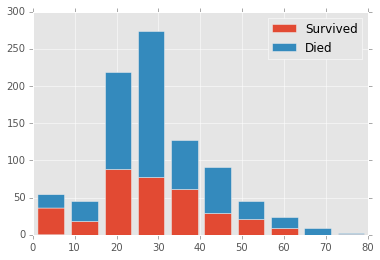

survived_age statistics
count    342.000000
mean      28.183709
std       14.007879
min        0.420000
25%       21.000000
50%       27.000000
75%       36.000000
max       80.000000
Name: filled_age, dtype: float64
died_age statistics
count    549.000000
mean      30.025651
std       12.769635
min        1.000000
25%       22.000000
50%       26.507589
75%       37.000000
max       74.000000
Name: filled_age, dtype: float64


In [122]:
survived_age =  titanic_data[titanic_data['Survived'] == 1]['filled_age']
died_age =  titanic_data[titanic_data['Survived'] == 0]['filled_age']
plt.hist([survived_age, died_age], stacked=True)
plt.legend(('Survived', 'Died'))
plt.show()
print "survived_age statistics"
print survived_age.describe()

print "died_age statistics"
print died_age.describe()

It seems the survival rate for people in their 30's is higher

Let's plot the age histograms of each class to see if the higher survival rate in class 1 is related to age of passengers in that class

Statistics of class 1 age
count    186.000000
mean      38.233441
std       14.802856
min        0.920000
25%       27.000000
50%       37.000000
75%       49.000000
max       80.000000
Name: Age, dtype: float64
Statistics of class 2 age
count    173.000000
mean      29.877630
std       14.001077
min        0.670000
25%       23.000000
50%       29.000000
75%       36.000000
max       70.000000
Name: Age, dtype: float64
Statistics of class 3 age
count    355.000000
mean      25.140620
std       12.495398
min        0.420000
25%       18.000000
50%       24.000000
75%       32.000000
max       74.000000
Name: Age, dtype: float64


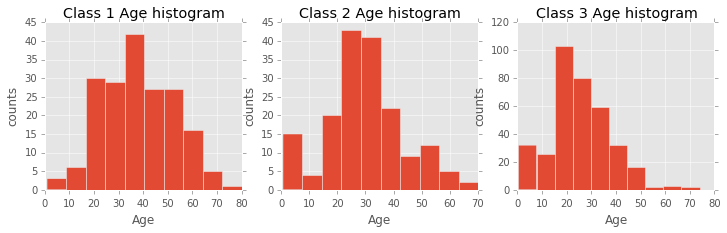

In [123]:
# Plot age histograms for passengers of each classes
#fig1, ((ax1, ax2, ax3)) = plt.subplots(1, 3)
fig1, ax = plt.subplots(1, 3)

plt.gcf().set_size_inches(12, 3)

class_age = []
age_hist_c = []
j = 0
for i in range(1,4):
    class_age.append(titanic_data[titanic_data['Pclass'] == int(i)]['Age'])
    print "Statistics of class " + str(i) + " age"
    print class_age[j].describe()
    age_hist_c.append(class_age[j].hist(ax = ax[j]))
    plot_hist(age_hist_c[j], ax[j], 'Class ' + str(i) + ' Age histogram', 'Age', 'counts')
    j = j + 1

The age peak for class 1 appears betweenn 30-40, that shows possible correlation between survival rate and passenger's age.
Overall, passengers in class 3 are younger and they have different distribution. Let's do a Mann-Whitney rank test to check this.

In [124]:
from scipy import stats
print 'Mann-Whitney rank test between class 1 and 2'
print stats.mannwhitneyu(class_age[0], class_age[1])
print 'Mann-Whitney rank test between class 1 and 3'
print stats.mannwhitneyu(class_age[0], class_age[2])
print 'Mann-Whitney rank test between class 2 and 3'
print stats.mannwhitneyu(class_age[1], class_age[2])

Mann-Whitney rank test between class 1 and 2
(13332.5, 6.9174325536509946e-09)
Mann-Whitney rank test between class 1 and 3
(44626.0, 0.00039097258657495192)
Mann-Whitney rank test between class 2 and 3
(42347.5, 0.10528046313690043)


This further shows age distribution of different classes of passengers does differ. 

Let's try to see if having a family member on board (siblings, spouses, parent, children) make passengers more likely to survive

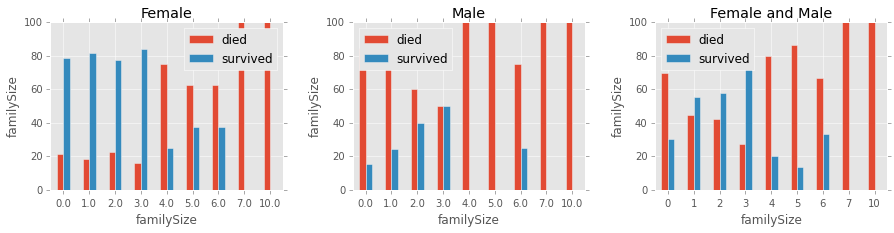

In [125]:
# Introduce a new column to store the family size
titanic_data['familySize'] = titanic_data['SibSp'] + titanic_data['Parch']
fig1, ((ax1, ax2, ax3)) = plt.subplots(1, 3)
plt.gcf().set_size_inches(15, 3)
fig1.subplots_adjust(wspace = 0.3)
# Calculate females survival rate based on family size
fem_with_fam = titanic_data[titanic_data['Sex'] == 'female']
fem_with_fam_survival = pd.crosstab(fem_with_fam['familySize'], titanic_data['Survived'])
# Compute the percentage
fem_with_fam_survival_prc = fem_with_fam_survival.div(fem_with_fam_survival.sum(axis = 1)/100, axis = 0)
# Change the column name to be less confusing
fem_with_fam_survival_prc.columns = ['died', 'survived']
# Plot the data
plot_bar_multi(fem_with_fam_survival_prc, ax1, 'Female',
                   'familySize', '%', 0, 100)

# Calculate males survival rate based on family size
male_with_fam = titanic_data[titanic_data['Sex'] == 'male']
male_with_fam_survival = pd.crosstab(male_with_fam['familySize'], titanic_data['Survived'])
# Compute the percentage
male_with_fam_survival_prc = male_with_fam_survival.div(male_with_fam_survival.sum(axis = 1)/100, axis = 0)
# Change the column name to be less confusing
male_with_fam_survival_prc.columns = ['died', 'survived']
# Plot the data
plot_bar_multi(male_with_fam_survival_prc, ax2, 'Male',
                   'familySize', '%', 0, 100)

# Calculate overall survival rate based on family size
pass_with_fam_survival = pd.crosstab(titanic_data['familySize'], titanic_data['Survived'])
# Compute the percentage
pass_with_fam_survival_prc = pass_with_fam_survival.div(pass_with_fam_survival.sum(axis = 1)/100, axis = 0)
# Change the column name to be less confusing
pass_with_fam_survival_prc.columns = ['died', 'survived']
# Plot the data
plot_bar_multi(pass_with_fam_survival_prc, ax3, 'Female and Male',
                   'familySize', '%', 0, 100)


Apparantly, for families of size 3 or smaller, there is a relationship beween survival rate and family size. The survival rate increases by increasing the family size when we look at only males and all passengers. The trend is not as clear if we only look at female passengers. We probably need to do some statistical tests to show the differences are meaningful but I am going to skip this analysis for now.

# Conclusions

According to the data explorations performed here, the following tentative conclusions can be drawn:
1) The survival rate was higher for passengers in class 1
2) The survival of passengers of 30-40 years old is higher than others.
3) Higher survival rate in class 1 could be related to higher population of 30-40 years old passengers in that class
4) The survival rate of female passengers is higher. 
5) It seems people who had some family members on board had higher chance of survival.

We must keep in mind that we only look at the data of 891 out of 2224 passengers (~40%) on board. The interpretation of data and the outcomes may change by looking at the complete set of information. Additionally, some values in the data set particularly "Age" column are missing which could influence our analysis. Furthermore, we need to perform more statistical tests to prove the differences between reported values are statistically significant. Lastly, the accuracy of the data is an important factor that we currently are not able to examine.

Kaggle website and its forum as well as the first reviewr's comments were used for brainstorming and possible approaches to explore the data.